<center>

<h1>Continuous Influencer Attachment Model: Supplementary Code</h1>
<p>Marios Papachristou (papachristoumarios@cs.cornell.edu)</p>
<p>Jon Kleinberg (kleinberg@cs.cornell.edu)</p>

</center>

## Dependencies

We install the following dependencies

In [ ]:
!pip install karateclub sparse --quiet

     |████████████████████████████████| 61kB 3.0MB/s 
     |████████████████████████████████| 81kB 6.8MB/s 
     |████████████████████████████████| 1.8MB 38.3MB/s 
     |████████████████████████████████| 23.9MB 57.2MB/s 


In [ ]:
!git clone https://github.com/ryanjgallagher/core_periphery_sbm.git
import sys
sys.path.insert(0,'core_periphery_sbm')

Cloning into 'core_periphery_sbm'...
remote: Enumerating objects: 46, done.
remote: Counting objects: 100% (46/46), done.
remote: Compressing objects: 100% (28/28), done.
remote: Total 46 (delta 19), reused 41 (delta 17), pack-reused 0
Unpacking objects: 100% (46/46), done.


## Imports

We perform the following imports in our python environment

In [ ]:
# Imports
import scipy.io
import os
import copy
import numpy as np
import networkx as nx
import matplotlib.pyplot as plt
import numpy as np
import networkx as nx
import collections
import matplotlib.pyplot as plt
import matplotlib.cm as cm
import matplotlib
import pandas as pd
import seaborn as sns
from google.colab import drive
drive.mount('/content/drive/')
import random
import itertools
import pystan
import pickle
import arviz as az
from sklearn import linear_model
from scipy.optimize import minimize
from scipy import stats
from scipy import special
from scipy import sparse as scipy_sparse
import sparse

# Aesthetics
LARGE_SIZE = 16
plt.rc('axes', labelsize=LARGE_SIZE)
plt.rc('axes', titlesize=LARGE_SIZE)
sns.set_theme()

Drive already mounted at /content/drive/; to attempt to forcibly remount, call drive.mount("/content/drive/", force_remount=True).


## Dataloaders

We define the dataloaders below

In [ ]:
def stanfit_to_dataframe(fit, params=None):
  data = fit.extract()
  result = {}
  if params is None:
    params = data.keys()
  
  for key in params:
    val = data[key]
    if len(val.shape) == 1:
      result[key] = val
    else:
      for i in range(val.shape[-1]):
        result['{}[{}]'.format(key, i)] = val[:, i]
  return pd.DataFrame.from_dict(data=result)

def load_world_trade(location='/content/drive/My Drive/NNIM/data/world-trade/world-trade.csv', relabel=True):
  df = pd.read_csv(location)
  G = nx.convert_matrix.from_pandas_edgelist(df, source='from', target='to')

  if relabel:
    G = nx.convert_node_labels_to_integers(G, label_attribute='name')
  
  return G

def load_faculty(location='/content/drive/My Drive/NNIM/data/faculty/ComputerScience_edgelist.txt', relabel=True):
  df = pd.read_csv(location, sep='\t')
  G = nx.convert_matrix.from_pandas_edgelist(df, source='# u', target='v')
  vertexlist_filename = location.replace('edgelist', 'vertexlist')
  vertex_df = pd.read_csv(vertexlist_filename, sep='\t')
  vertex_df.set_index('# u', inplace=True)
  mapping = vertex_df['institution'].to_dict()
  nx.set_node_attributes(G, mapping, 'name')

  if relabel:
    G = nx.convert_node_labels_to_integers(G, label_attribute='name')
  return G

def load_polblogs(location='/content/drive/My Drive/NNIM/data/polblogs/polblogs.mtx', relabel=True):
  df = pd.read_csv(location, sep=' ', comment='%', header=None)
  G = nx.convert_matrix.from_pandas_edgelist(df, source=0, target=1)
  if relabel:
    G = nx.convert_node_labels_to_integers(G, label_attribute='name')

  return G

def load_airports(location='/content/drive/My Drive/NNIM/data/airports/USairport500.txt', relabel=True):
  df = pd.read_csv(location, sep=' ', header=None)
  G = nx.convert_matrix.from_pandas_edgelist(df, source=0, target=1)
  if relabel:
    G = nx.convert_node_labels_to_integers(G, label_attribute='name')
  return G

def load_pvc_enron(location='/content/drive/My Drive/NNIM/data/pvc-enron/pvc-enron.csv', relabel=True):
  df = pd.read_csv(location, sep=' ', header=None)
  G = nx.convert_matrix.from_pandas_edgelist(df, source=0, target=1, create_using=nx.Graph)
  if relabel:
    G = nx.convert_node_labels_to_integers(G, label_attribute='name')
  return G

def load_pvc_text_Reality(location='/content/drive/My Drive/NNIM/data/pvc-text-Reality/pvc-text-Reality.csv', relabel=True):
  df = pd.read_csv(location, sep=' ', header=None)
  G = nx.convert_matrix.from_pandas_edgelist(df, source=0, target=1, create_using=nx.Graph)
  if relabel:
    G = nx.convert_node_labels_to_integers(G, label_attribute='name')
  return G 

def load_celegans(location='/content/drive/My Drive/NNIM/data/celegans', relabel=True):
  A = np.genfromtxt(os.path.join(location, 'celegans_matrix.csv'), delimiter=',', dtype=np.int64).astype(np.int64)
  locs = np.genfromtxt(os.path.join(location, 'celegans_positions.csv'), delimiter=',').astype(np.float64)
  mapping = {}
  for i, loc in enumerate(locs):
    mapping[i] = loc

  G = nx.from_numpy_array(A)

  Gccs = sorted(nx.connected_components(G), key=len, reverse=True)
  G = G.subgraph(Gccs[0])

  nx.set_node_attributes(G, mapping, "location")

  if relabel:
    G = nx.convert_node_labels_to_integers(G, label_attribute='name')

  return G

def load_london_underground(location='/content/drive/My Drive/NNIM/data/london_underground', relabel=True):
  A = np.genfromtxt(os.path.join(location, 'london_underground_network.csv'), delimiter=',', dtype=np.int64).astype(np.int64)
  locs = np.genfromtxt(os.path.join(location, 'london_underground_tubes.csv'), delimiter=',').astype(np.float64)
  names = np.genfromtxt(os.path.join(location, 'london_underground_names.csv'), delimiter='\t', dtype=str)

  mapping = {}
  for i, loc in enumerate(locs):
    mapping[i] = loc

  names_mapping = {}
  for i, name in enumerate(names):
    names_mapping[i] = name

  G = nx.from_numpy_array(A)

  Gccs = sorted(nx.connected_components(G), key=len, reverse=True)
  G = G.subgraph(Gccs[0])

  nx.set_node_attributes(G, mapping, "location")
  nx.set_node_attributes(G, names_mapping, "name")

  if relabel:
    G = nx.convert_node_labels_to_integers(G, label_attribute='name')

  return G

def load_open_airlines(location='/content/drive/My Drive/NNIM/data/open_airlines', relabel=True):
  airports = pd.read_csv(os.path.join(location, 'airports.dat'), header=None).iloc[:, [4, 6, 7]]
  routes = pd.read_csv(os.path.join(location, 'routes.dat'), header=None).iloc[:, [2, 4]]
  G = nx.convert_matrix.from_pandas_edgelist(routes, source=2, target=4, create_using=nx.Graph)
  Gccs = sorted(nx.connected_components(G), key=len, reverse=True)
  G = G.subgraph(Gccs[0])
  mapping = {}
  for i, x in airports.iterrows():
    if G.has_node(x[4]):
      mapping[x[4]] = np.array([x[6], x[7]])

  nx.set_node_attributes(G, mapping, "location")

  if relabel:
    G = nx.convert_node_labels_to_integers(G, label_attribute='name')

  return G  

def load_fungal(location='/content/drive/My Drive/NNIM/data/fungal_networks', fungus='Pv_M_I_U_N_42d_1.mat', relabel=True):
  mat = scipy.io.loadmat(os.path.join(location, fungus))
  G = nx.from_scipy_sparse_matrix(mat['A'], create_using=nx.Graph)
  mapping = {}

  for i in range(mat['coordinates'].shape[0]):
      mapping[i] = mat['coordinates'][i]

  nx.set_node_attributes(G, mapping, 'location')  
  
  if relabel:
    G = nx.convert_node_labels_to_integers(G, label_attribute='name')

  return G

def load_ca_netscience(location='/content/drive/My Drive/NNIM/data/ca-netscience/ca-netscience.mtx', relabel=True):
  df = pd.read_csv(location, sep=' ', header=None, skiprows=2)
  G = nx.convert_matrix.from_pandas_edgelist(df, source=0, target=1, create_using=nx.Graph)
   
  if relabel:
    G = nx.convert_node_labels_to_integers(G, label_attribute='name')

  return G

class Simplex:

  def __init__(self, nodes=[], timestamp=None):
    self.nodes = nodes
    self.timestamp = timestamp

  def __len__(self):
    return len(self.nodes)

  def add_node(self, node):
    self.nodes.append(node)

class Hypergraph:

  def __init__(self):
    self.nodes = collections.defaultdict(bool)
    self.simplices = []
    self.pointers = collections.defaultdict(list)
    self.graph = nx.Graph()
    self.node_data = collections.defaultdict(dict)

  def add_simplex_from_nodes(self, nodes, timestamp=None):
    simplex = Simplex(nodes=nodes, timestamp=timestamp)
    self.add_simplex(simplex)

  def add_simplex(self, simplex):
    self.simplices.append(simplex)
    for node in simplex.nodes:
      self.nodes[node] = True
      self.pointers[node].append(len(self.simplices) - 1)
    
    for u in simplex.nodes:
      for v in simplex.nodes:
        if u != v:
          self.graph.add_edge(u, v, timestamp=simplex.timestamp)

  def __getitem__(self, node):
    return self.node_data[node]

  def set_attribute(self, node, key, value):
    self.node_data[node][key] = value

  def __setitem__(self, node, data):
    assert(isinstance(data, dict))
    self.node_data[node] = data
    return data

  def simplex_neighbors(self, node):
    for pointer in self.pointers[node]:
      yield self.simplices[pointer]

  def nodes(self):
    for key in self.nodes:
      yield key

  def simplices_iter(self):
    for simplex in self.simplices:
      yield simplex

  def __len__(self):
    return len(self.nodes)
  
  def num_simplices(self):
    return len(self.simplices)

  def degrees(self):
    degrees = collections.defaultdict(int)
    for simplex in self.simplices:
      for node in simplex.nodes:
        degrees[node] += 1
    
    return degrees

  @staticmethod
  def graph_to_hypergraph(G):
    H = Hypergraph()
    for (u, v) in G.edges():
      smp = Simplex([u, v])
      H.add_simplex(smp)

    return H

  def set_node_attributes_to_graph(self, G):
    nx.set_node_attributes(G, self.node_data, "data")
    return G

  def clique_decomposition(self):
    G = nx.Graph()
    for simplex in self.simplices:
      for i in range(len(simplex.nodes)):
        for j in range(i):
          G.add_edge(simplex.nodes[i], simplex.nodes[j])

    G = self.set_node_attributes_to_graph(G)

    return G

  def star_decomposition(self):
    G = nx.Graph()
    for simplex in self.simplices:
      node_name = ','.join([str(node) for node in simplex.nodes])
      for u in simplex.nodes:
        G.add_edge(u, node_name)

    G = self.set_node_attributes_to_graph(G)

    return G

  def to_csr(self):
    temp_indices = collections.defaultdict(list)
    for simplex in self.simplices:
      temp_indices[len(simplex)].append(simplex.nodes)

    csr = {}

    for key in temp_indices:
      coords = np.array(temp_indices[key]).T
      data = 1
      shape = tuple(key * [self.__len__(), ])
      csr[key] = sparse.COO(coords=coords, data=data)

    return csr

  def to_dense(self):
    csr = self.to_csr()
    dense = {}
    for key, val in csr.items():
      dense[key] = val.todense()

    return dense

def load_ghtorrent_projects(location='/content/drive/My Drive/NNIM/data/ghtorrent-projects-hypergraph', simplex_min_size=2, simplex_max_size=2, relabel=True):
  df = pd.read_csv(os.path.join(location, 'project_members.txt'), sep='\t')
  df = df[(df.simplex_size >= simplex_min_size) & (df.simplex_size <= simplex_max_size)]

  H = Hypergraph()

  for i, row in df.iterrows():
    simplex = Simplex([int(x) for x in row['simplex'].split(',')], timestamp=row['created_at'])
    H.add_simplex(simplex)

  num_followers = pd.read_csv(os.path.join(location, 'num_followers.txt'), sep='\t')
  num_followers = num_followers[num_followers['user_id'].isin(list(H.nodes.keys()))]
  num_followers['log_num_followers'] = np.log(num_followers['num_followers'])

  for i, row in num_followers.iterrows():
    H.set_attribute(row['user_id'], 'log_num_followers', row['log_num_followers'])
    H.set_attribute(row['user_id'], 'num_followers', row['num_followers'])

  return H, num_followers


def load_hypergraph(name='email-Enron', location='/content/drive/My Drive/NNIM/data'):
  nverts = np.genfromtxt(os.path.join(location, name, '{}-nverts.txt'.format(name)), delimiter=',', dtype=np.int64)
  simplices = np.genfromtxt(os.path.join(location, name, '{}-simplices.txt'.format(name)), delimiter=',', dtype=np.int64)
  times = np.genfromtxt(os.path.join(location, name, '{}-times.txt'.format(name)), delimiter=',', dtype=np.int64)

  H = Hypergraph()
  j = 0

  for nvert, timestamp in zip(nverts, times):
    simplex = Simplex([], timestamp)
    for i in range(nvert):
      simplex.add_node(simplices[j])
      j += 1
      
    H.add_simplex(simplex)    

  return H

In [ ]:
def mns(H, s):
  if isinstance(H, Hypergraph):
    u0, v0 = random.choice(list(H.graph.edges())) 
  elif isinstance(H, nx.Graph):
    u0, v0 = random.choice(list(H.edges()))
  f = set([u0, v0])

  while len(f) < s:
    S = set([])
    for u in f:
      if isinstance(H, Hypergraph):
        for v in H.graph.neighbors(u):
          S |= {(u, v)}
      elif isinstance(H, nx.Graph):
        for v in H.neighbors(u):
          S |= {(u, v)}

    if len(S) == 0:
      return mns(H, s)
    else:
      u, v = random.choice(list(S))
      f |= {u, v}

  return f

def cns(H, s):
  f = set(random.choice(H.simplices).nodes)
  v = random.choice(list(f))
  
  while len(f) < s:
    V = set([])
    for u in f - {v}:
      for smp in H.simplex_neighbors(u):
        for w in smp.nodes:  
          V |= {w}

    if len(V) == 0:
      return cns(H, s)
    else:
      v1 = random.choice(list(V))
      f = (f - {v}) | {v1}
  return f

## CIGAM Model

### Bayesian Model

#### Single-layer model

We use the following bayesian model that creates a single layer core-periphery network 

\begin{align}
  \lambda & \sim \mathrm{Gamma} (\alpha, \beta) \\
  r(u) | \lambda & \sim \mathrm{TruncExp} (\lambda, [0, H])  & \forall u \in V \\
  X(u, v) | r(u), r(v) & \sim \mathrm{Bern} \left ( c^{-1-H + \max \{ r(u), r(v) \}} \right ) & \forall (u, v) \in V \times V
\end{align}

The truncated exponential is equivalent to the continuous tree distribution 

$$p(h(u)) \propto b^{h(u)} \mathbf 1 \{ h(u) \in [0, H] \}$$

for $h(u) = H - r(u)$ for $\lambda = \log b$. 

When a hypergraph is generated, then the corresponding hyperedge $e$ is generated, mutatis mutandis, with probability $c^{-1-H + \max_{u \in e} \{ r(u) \}}$.  

#### Multi-layer model

The previous model has a multi-layer extension, where the parametrization depends on $\lambda > 0$ as previously as well as $\ell \ge 1$ layers parametrized by $1 < c_1 \le c_2 \le \dots \le c_\ell \le b$ and $H_0 = 0 \le H_1 \le H_2 \le \dots H_{\ell} = H$. We also define the following mapping $\phi(h(e))$ that gets an (hyper)edge as an input and maps it to $\{ c_i \}_{i \in [\ell]}$ as follows: If $H_{i - 1} \le \max_{u \in E} \{ h(u) \} \le H_i$ then $\phi(h(e)) = c_i$. Then the bayesian model for a $k$-uniform hypergraph is defined as follows: 

\begin{align}
  \lambda & \sim \mathrm{Gamma} (\alpha, \beta) \\
  r(u) | \lambda & \sim \mathrm{TruncExp} (\lambda, [0, H])  & \forall u \in V \\
  X(u, v) | r(e) & \sim \mathrm{Bern} \left ( f(H - r(e)))^{-1-H + \max_{u \in E} \{ r(u) \}} \right ) & \forall e \in V^k
\end{align}

#### Generalized Model

The generalized model replaces the quantity $\max_{u \in e} \{ r(u) \} = \| r (e) \|_{\infty}$ with the generalized $p$-mean 

$$M_\delta (r(e)) = \frac {\| r(e) \|_{p}}{ |e|^{1 / p}}$$

where $|e|$ is the size of the hyperedge $e$. The single-layer model can be obtained by letting $p \to +\infty$ and a variety of interesting models emerges for the cases of $p \in \{ 0, 1, 2 \}$. 

In [ ]:
class CIGAM:

  def __init__(self, c=[1.5], b=3, H=[4]):

    if isinstance(c, float):
      self.c = np.array([c])
    else:
      self.c = np.array(c)

    if isinstance(H, float):
      self.H = np.array([H])
    else:
      self.H = np.array(H)
    
    assert(np.all(self.c == np.sort(self.c)))
    assert(c[0] >= 1 and c[-1] <= b)
    assert(np.all(H == np.sort(H)))
    assert(len(self.H) == len(self.c))
    assert(b > 1)

    self.lambda_ = np.log(b)
    self.num_layers = len(self.c)
    
    self.stan_definitions = {
        'N' : 'int N;',
        'L' : 'int L;',
        'H' : 'real H[L];',
        'b' : 'real<lower=1> b;',
        'lambda' : 'real<lower=0> lambda;',
        'c' : 'real<lower=1> c[L];',
        'A' : 'int<lower=0, upper=1> A[N, N];',
        'heights' : 'real<lower=0, upper=H[L]> heights[N];',
        'ranks' : 'real<lower=0, upper=H[L]> ranks[N];'
    }

  def c_helper(self, h):
    h_max = np.max(h)
    idx = np.where(h_max <= self.H)[0][0]
    return self.c[idx]

  @property
  def b(self):
    return np.exp(self.lamdba_)

  @b.getter
  def b(self):
    return np.exp(self.lambda_)

  @b.setter
  def b(self, b_):
    self.lambda_ = np.log(b_)
    return b_

  def sample(self, N, return_ranks=True):
    h = self.continuous_tree_sample(N=N)
    h = np.sort(h)

    G = nx.Graph()

    for u in range(N):
      G.add_node(u)
      for v in range(u):
        idx = np.array([u, v])
        if u != v and np.random.uniform() <= self.c_helper(h[idx])**(-1-h[idx].min()):
          G.add_edge(u, v)
       
    if return_ranks:
      return G, self.H[-1] - h
    else:
      return G, h

  def plot_sample(self, n):
    G, h = self.sample(n)
    A = nx.to_numpy_array(G)
    plt.figure(figsize=(10, 10))
    plt.imshow(A)
    plt.title('Adjacency Matrix for G ~ CIGAM($c$={}, $b$={}, $H$={})'.format(self.c, self.b, self.H))
    plt.xlabel('Ranked Nodes by $h(u)$')
    plt.ylabel('Ranked Nodes by $h(u)$')
    plt.figure(figsize=(10, 10))
    log_rank = np.log(1 + np.arange(A.shape[0]))
    log_degree = np.log(1 + A.sum(0))
    log_degree = -np.sort(-log_degree)
    p = np.polyfit(log_rank, log_degree, deg=1)
    alpha_lasso = 0.1
    clf_lasso = linear_model.Lasso(alpha=alpha_lasso)
    clf_lasso.fit(log_rank.reshape(-1, 1), log_degree)
    r2 = np.corrcoef(log_rank, log_degree)[0, 1]
    plt.plot(log_rank, log_degree, linewidth=1, label='Realized Degree $R^2 = {}$'.format(round(r2, 2)))
    plt.plot(log_rank, p[1] + p[0] * log_rank, linewidth=2, label='Linear Regression')
    plt.plot(log_rank, clf_lasso.intercept_ + clf_lasso.coef_ * log_rank, linewidth=2, label='Lasso Regression ($a = {}$)'.format(alpha_lasso))
    plt.xlabel('Node Rank by $h(u)$ (log)')
    plt.ylabel('Node Degree (log)')
    plt.title('Degree Plot')
    plt.legend()

  def stan_model(self, known, dump=True, load=True):

    functions_segment = '''functions {
  int find_c(real h_max, real[] h_values, int len) {
    int j;
    j = 1;
    while (h_max >= h_values[j] && j <= len) j = j + 1;
    return j;

  }
}'''

    model_segment = '''model {

      lambda ~ gamma(2, 2);
      c ~ pareto(1, 2);
      ranks ~ exponential(lambda);
  
      for (i in 1:N) {
        for (j in 1:N) {
          if (ranks[i] >= ranks[j]) A[i, j] ~ bernoulli(pow(c[find_c(H[L] - ranks[j], H, L)], -1-H[L]+ranks[i]));
          else A[i, j] ~ bernoulli(pow(c[find_c(H[L] - ranks[i], H, L)], -1-H[L]+ranks[j]));
        }
      }
}
    '''

    data = []
    params = []
    data_keys = []
    params_keys = []

    for key, val in known.items():
      if val:
        data.append(self.stan_definitions[key])
        data_keys.append(key)
      else:
        params.append(self.stan_definitions[key])
        params_keys.append(key)
    
    data_text = '\n\t'.join(data)
    params_text = '\n\t'.join(params)

    data_segment = 'data {\n\t' + data_text + '\n}'
    params_segment = 'parameters {\n\t' + params_text + '\n}'  

    model_code = '{}\n\n{}\n\n{}\n\n{}'.format(functions_segment, data_segment, params_segment, model_segment)

    model_name = '{}_given_{}'.format('_'.join(params_keys), '_'.join(data_keys))

    if load:
      if os.path.isfile('{}.pickle'.format(model_name)):
        with open('{}.pickle'.format(model_name), 'rb') as f:
          stan_model = pickle.load(f)
        return stan_model
      else: 
        stan_model = pystan.StanModel(model_code=model_code, model_name=model_name)
    else:
      stan_model = pystan.StanModel(model_code=model_code, model_name=model_name)
      
    if dump:
      with open('{}.pickle'.format(model_name), 'wb+') as f:
        pickle.dump(stan_model, f, protocol=-1)
      with open('{}.stan'.format(model_name), 'w+') as f:
        f.write(model_code)

    return stan_model

  def continuous_tree_sample(self, N):
    u = np.random.uniform(size=N)
    y = np.log(u * (self.b**self.H[-1] - 1) + 1) / np.log(self.b) 
    return y

  def stan_model_sample(self, known, model_data, dump=True, load=True):
    stan_model = self.stan_model(known, dump=dump, load=load)
    fit = stan_model.sampling(data=model_data, iter=500, chains=4)

    return fit

  def params_posterior(self):
    known = {
        'N' : True,
        'L' : True,
        'H' : True,
        'A' : True,
        'ranks' : True,
        'lambda' : False,
        'c' : False
    }

    return known

  def latent_posterior(self):
    known = {
        'N' : True,
        'L' : True,
        'H' : True,
        'A' : True,
        'ranks' : False,
        'lambda' : True,
        'c' : True
    }

    return known

  def params_latent_posterior(self):
    known = {
        'N' : True,
        'L' : True,
        'H' : True,
        'A' : True,
        'ranks' : False,
        'lambda' : False,
        'c' : False
    }

    return known

  def visualize_posterior(self, fit, params=None, pairplot=False):

    if params is None:
      params = list(fit.extract().keys())

    df = stanfit_to_dataframe(fit, params)

    params = [col for col in df.columns]

    print(params)

    if pairplot:
      sns.pairplot(df, x_vars=params, y_vars=params, kind='kde')
      
    else:
      fig, ax = plt.subplots(figsize=(10, 10))
      colors = iter(cm.rainbow(np.linspace(0, 1, len(params))))

      for param in params:
        if param == 'lp__':
          continue
        c = next(colors)
        param_mean = round(df[param].mean(), 2)
        param_std = round(df[param].std(), 2)
        sns.histplot(df[param], kde=True, label='{} (mean = {}, std = {})'.format(param, param_mean, param_std), ax=ax, color=c)

      plt.xlabel('Parameters')
      plt.ylabel('Posterior')
      plt.legend()

  def visualize_degree_plot(self, G, fit):
    
    
    degrees_init = 1 + np.array([G.degree(u) for u in range(len(G))])
    
    ranks = fit.extract()['ranks']
    degrees = np.zeros_like(ranks)
    
    A = nx.to_numpy_array(G)
    A_mean = np.zeros_like(A)

    for i in range(ranks.shape[0]):
      
      positions = np.argsort(-ranks[i, :])
      degrees[i, :] = degrees_init[positions]

      for i in range(A.shape[0]):
        A[i, :] = A[i, positions]

      for i in range(A.shape[1]):
        A[:, i] = A[positions, i]

      A_mean += A

    degrees_mean = degrees.mean(0)
    degrees_std = degrees.std(0)
    x_axis = np.arange(1, len(degrees_mean) + 1)
    log_x_axis = np.log(x_axis)

    plt.figure(figsize=(10, 10))

    plt.plot(log_x_axis, np.log(degrees_mean), 'k-', color='blue', label='Empirical Mean Degrees wrt to Rankings')
    plt.fill_between(log_x_axis, np.log(degrees_mean-degrees_std), np.log(degrees_mean+degrees_std), color='blue', alpha=0.3)

    degrees_init = -np.sort(-degrees_init)

    plt.plot(log_x_axis, np.log(degrees_init), marker=11, color='red', linewidth=0, label='Actual Degrees')

    plt.title('Degree Plot')
    plt.xlabel('Ranking')
    plt.ylabel('Degree')
    plt.legend()

    # plt.figure(figsize=(10, 10))
    # plt.imshow(A_mean)
    # plt.xlabel('Ranking')
    # plt.ylabel('Ranking')
    # plt.title('Expected Adjacency Matrix wrt to Rankings')
  
  def fit_model_bayesian_em(self, G, H, lambda_init=np.log(3.2), c_init=1.4, epochs=30):

    lambda_old = lambda_init
    b_old = np.exp(lambda_old)
    c_old = c_init
    N = len(G)
    A = nx.to_numpy_array(G).astype(np.int64)

    optimum = (-np.inf, (lambda_old, b_old, c_old))

    for _ in range(epochs):
      # E-Step: Sample from p(heights | G, b_old, c_old)
      e_data = {
          'N' :  N,
          'L' : len(H),
          'H' : H,
          'A' : A,
          'lambda' : lambda_old,
          'c' : c_old
      }

      e_fit = cigam.stan_model_sample(cigam.latent_posterior(), e_data)

      # For every node let its rank be the mean of the corresponding sampled parameter heights[i]
      e_ranks = e_fit.extract()['ranks'].mean(0)

      # (Bayesian) M-Step: Sample from p(b, c | G, heights_avg)
      m_data = {
          'N' : N,
          'L' : len(H),
          'H' : H,
          'A' : A,
          'ranks' : e_ranks
      }

      # Let the parameters of the next iteration be the mean of the predicted parameters
      m_fit = cigam.stan_model_sample(cigam.params_posterior(), m_data)
      self.lambda_ = m_fit.extract()['lambda'].mean()
      self.b = np.exp(m_fit.extract()['lambda']).mean()
      self.c = m_fit.extract()['c'].mean(0)
      q_function = CIGAM.q_function(G, e_fit.extract()['ranks'], H, self.b, self.c)

      print('lambda = {}, c = {}, b = {}, Q = {}'.format(self.lambda_, self.c, self.b, q_function))

      if q_function >= optimum[0]:
        optimum = (q_function, (self.lambda_, self.b, self.c))

      lambda_old, c_old, b_old = self.lambda_, self.c, self.b

    self.lambda_, self.b, self.c = optimum[-1]
    print('Best fit', optimum)

    return optimum

  def fit_model_em(self, G, H, lambda_init=np.log(3.2), c_init=1.4, epochs=15):

    lambda_old = lambda_init
    b_old = np.exp(lambda_old)
    c_old = c_init
    N = len(G)
    A = nx.to_numpy_array(G).astype(np.int64)

    optimum = (-np.inf, (lambda_old, b_old, c_old))

    bounds = ((1, np.inf), (1, np.inf))
    q_values = []

    for _ in range(epochs):
      # E-Step: Sample from p(heights | G, b_old, c_old)
      e_data = {
          'N' :  N,
          'L' : len(H),
          'H' : H,
          'A' : A,
          'lambda' : lambda_old,
          'c' : c_old
      }

      e_fit = cigam.stan_model_sample(cigam.latent_posterior(), e_data)

      m_objective = lambda x: -CIGAM.q_function(G, e_fit.extract()['ranks'], H, x[0], x[1])

      res = minimize(m_objective, np.array([np.exp(lambda_old), c_old]), method='L-BFGS-B', bounds=bounds)

      self.b = res.x[0]
      self.c = res.x[1]
      self.lambda_ = np.log(self.b)
      q_function = -res.fun 
      q_values.append(q_function)

      print('lambda = {}, c = {}, b = {}, Q = {}'.format(self.lambda_, self.c, self.b, q_function))

      if q_function >= optimum[0]:
        optimum = (q_function, (self.lambda_, self.b, self.c))

      if np.allclose(self.c, c_old) and np.allclose(self.b, b_old):
        break

      lambda_old, c_old, b_old = self.lambda_, self.c, self.b

    self.lambda_, self.b, self.c = optimum[-1]
    print('Best fit', optimum)

    plt.figure(figsize=(10, 10))
    plt.plot(q_values)

    return optimum

  def fit_model_bayesian(self, G, H):
    data = {
        'N' : len(G),
        'L' : len(H),
        'H' : H,
        'A' : nx.to_numpy_array(G).astype(np.int64)
    }

    fit = cigam.stan_model_sample(cigam.params_latent_posterior(), data)

    self.lambda_ = fit.extract()['lambda'].mean()
    self.b = np.exp(fit.extract()['lambda']).mean()
    self.c = fit.extract()['c'].mean(0)
    self.H = H

    return fit

  def backup_params(self):
    self.b_backup = self.b
    self.c_backup = self.c
    self.lambda_backup = self.lambda_
    self.H_backup = self.H
  
  def restore_params(self):
    self.b = self.b_backup
    self.c = self.c_backup
    self.lambda_ = self.lambda_backup
    self.H = self.H_backup

  @staticmethod
  def ranks_log_likelihood(ranks, H, b):
    return (np.log(np.log(b)) - np.log(b**H - 1) + (H - ranks) * np.log(b)).sum()

  @staticmethod
  def graph_log_likelihood(G, ranks, H, c):
    heights = H - ranks
    result = 0
    for u in G:
      for v in G:
        if u != v:
          if G.has_edge(u, v):
            result += np.log(c**(-1 - min(heights[u], heights[v])))
          else:
            result += np.log(1 - c**(-1 - min(heights[u], heights[v])))
    return result

  @staticmethod
  def complete_log_likelihood(G, ranks, H, b, c):
    return CIGAM.ranks_log_likelihood(ranks, H, b) + CIGAM.graph_log_likelihood(G, ranks, H, c)

  @staticmethod
  def q_function(G, ranks_post, H, b, c):
    return np.mean([CIGAM.complete_log_likelihood(G, ranks_post[i, :], H, b, c) for i in range(ranks_post.shape[0])])  

class CIGAMGeneralizedMean(CIGAM):

  def __init__(self, c=[1.5,], b=3, H=[4,], p=-np.inf):

    self.p = p

    if isinstance(c, float):
      self.c = np.array([c])
    else:
      self.c = np.array(c)

    if isinstance(H, float):
      self.H = np.array([H])
    else:
      self.H = np.array(H)
    
    assert(np.all(self.c == np.sort(self.c)))
    assert(c[0] >= 1 and c[-1] <= b)
    assert(np.all(H == np.sort(H)))
    assert(len(self.H) == len(self.c))
    assert(b > 1)

    self.lambda_ = np.log(b)
    self.num_layers = len(self.c)
    
    self.stan_definitions = {
        'N' : 'int N;',
        'L' : 'int L;',
        'H' : 'real H[L];',
        'b' : 'real<lower=1> b;',
        'lambda' : 'real<lower=0> lambda;',
        'c' : 'real<lower=1> c[L];',
        'A' : 'int<lower=0, upper=1> A[N, N];',
        'heights' : 'real<lower=0, upper=H[L]> heights[N];',
        'ranks' : 'real<lower=0, upper=H[L]> ranks[N];'
    }

  def c_helper(self, h):
    h_max = h.max()
    idx = np.where(h_max <= self.H)[0][0]
    return self.c[idx]

  
  def sample(self, N, return_ranks=True):
    h = self.continuous_tree_sample(N=N)
    h = np.sort(h)

    G = nx.Graph()

    for u in range(N):
      G.add_node(u)
      for v in range(u):
        idx = np.array([u, v])
        if u != v and np.random.uniform() <= self.c_helper(h[idx])**(-1-generalized_mean(h[idx], self.p)):
          G.add_edge(u, v)
       
    if return_ranks:
      return G, self.H[-1] - h
    else:
      return G, h  

    def plot_sample(self, n):
      super().plot_sample(n)

p = -2
p = -4
p = -8
p = -16
p = -32
p = -inf


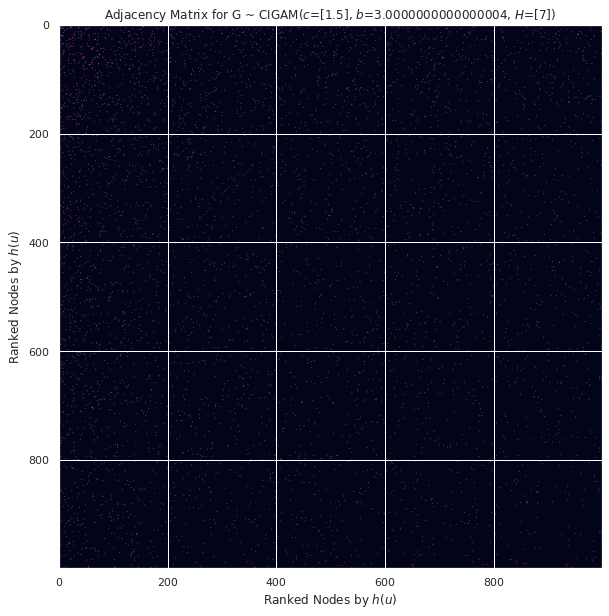

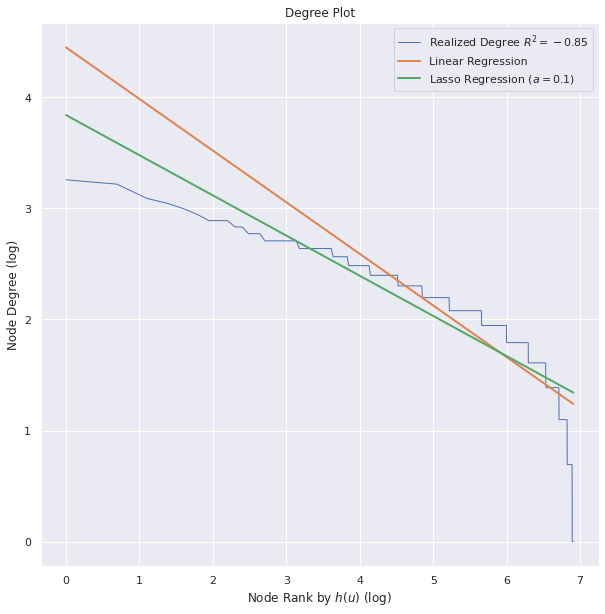

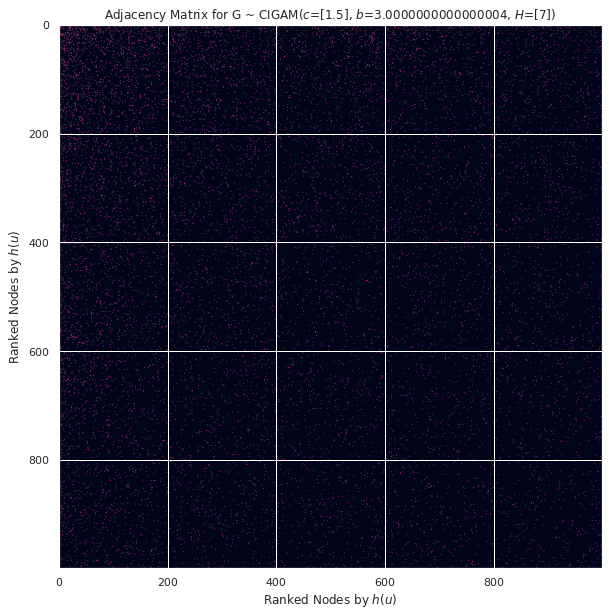

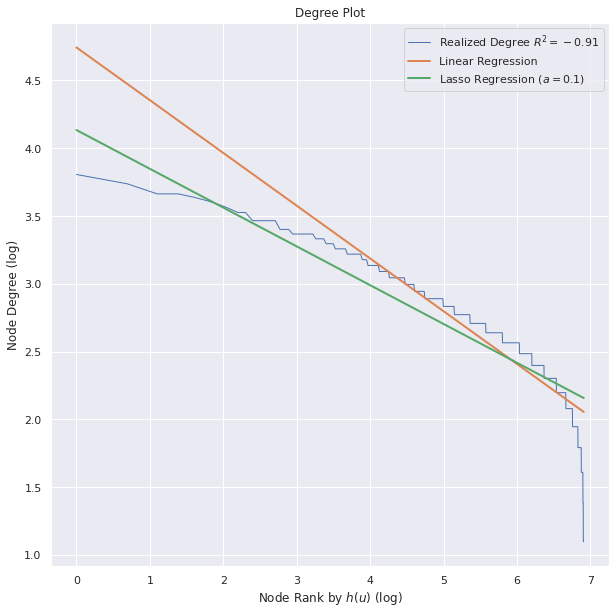

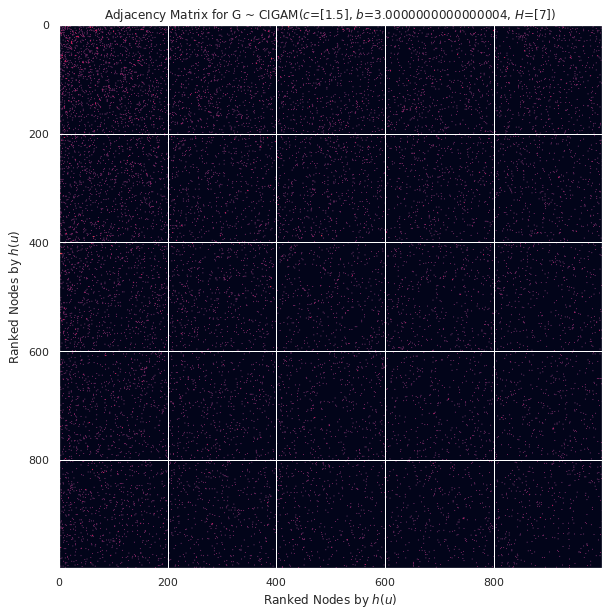

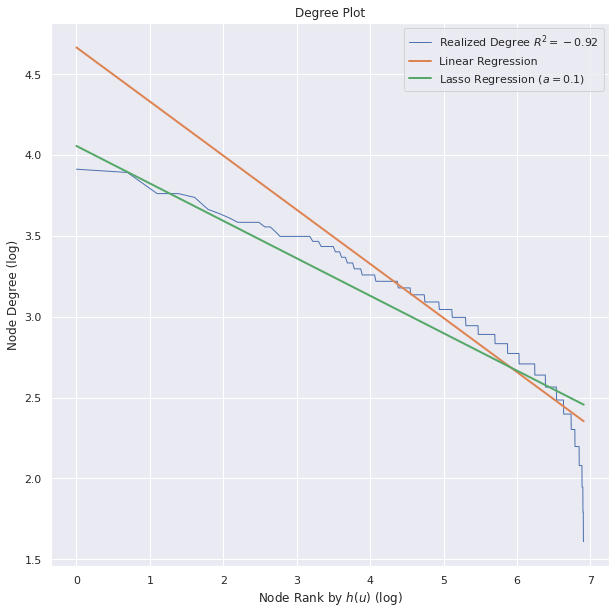

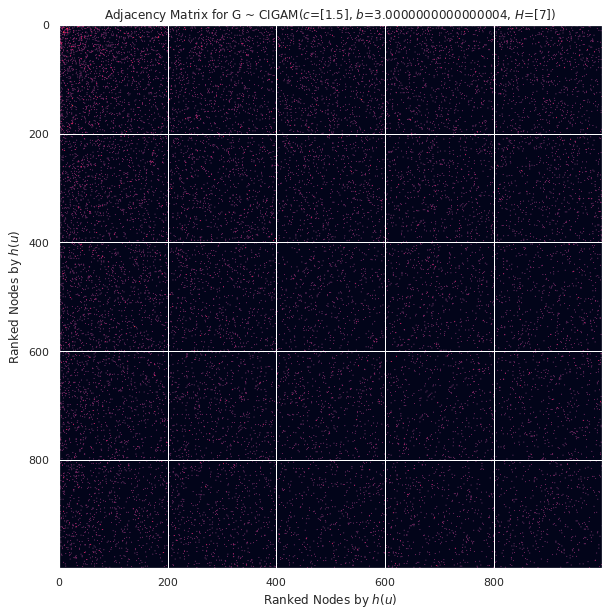

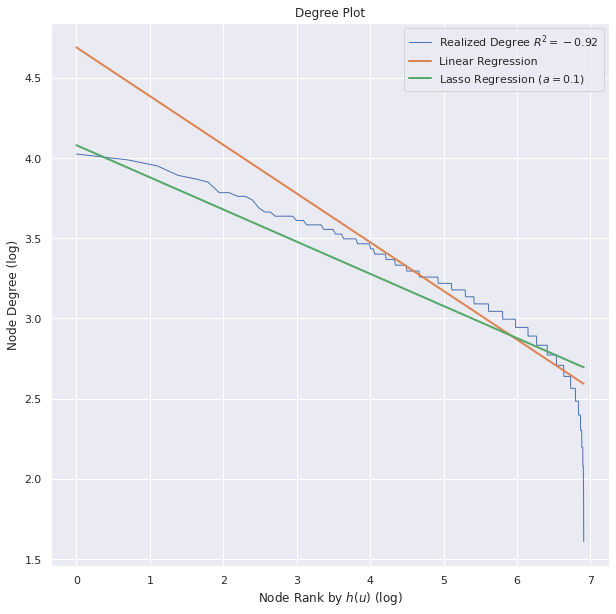

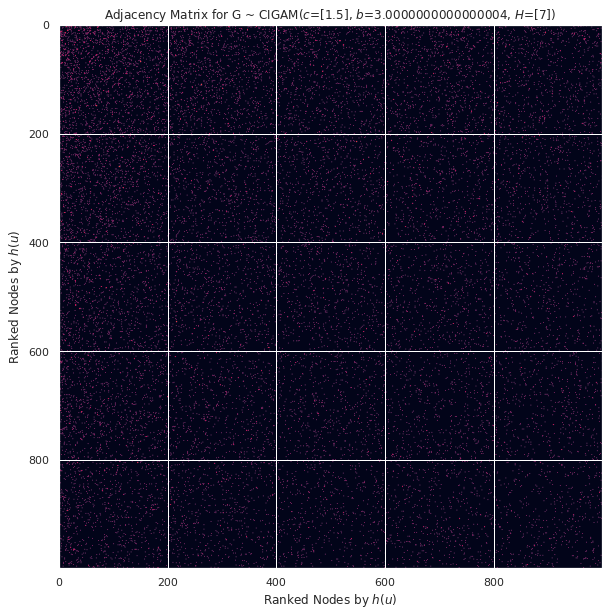

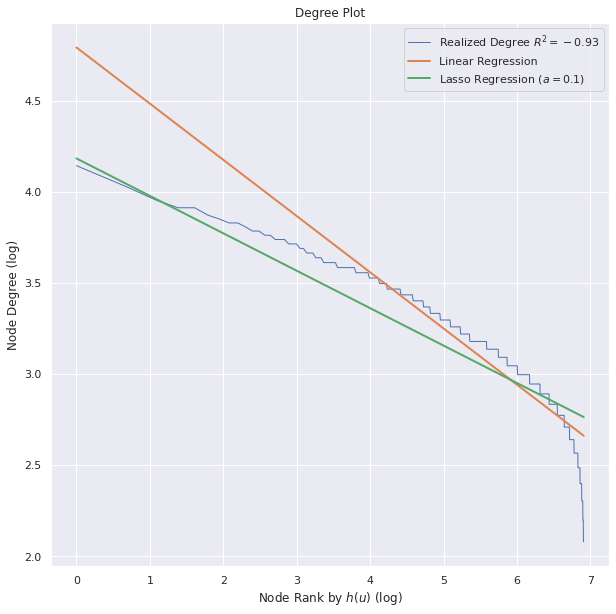

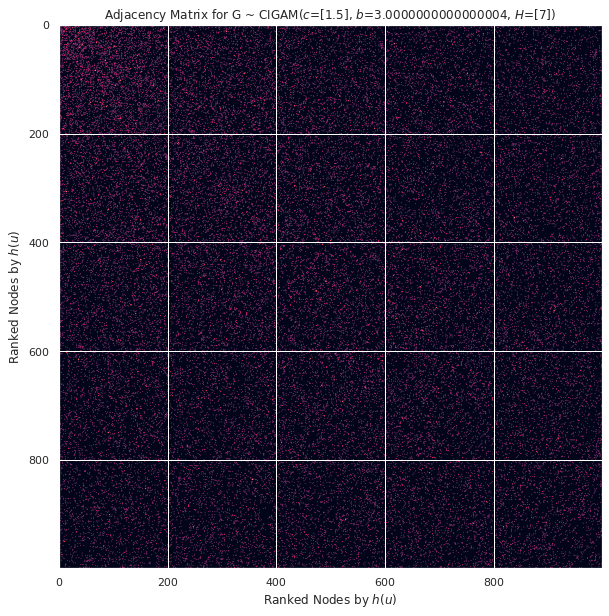

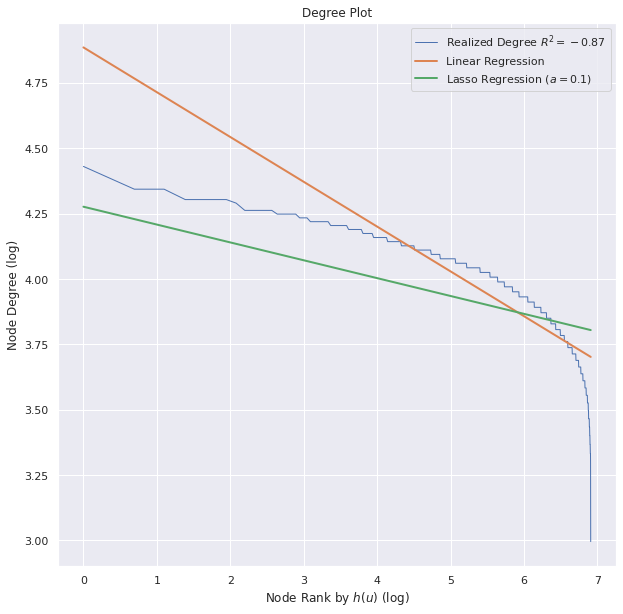

In [ ]:
for p in [-2, -4, -8, -16, -32, -np.inf]:
  print('p = {}'.format(p))
  cigam_generalized = CIGAMGeneralizedMean(c=[1.5], b=3, H=[7], p=p)
  cigam_generalized.plot_sample(1000)


We fit CIGAM to the world-trade dataset

['lambda', 'c[0]']


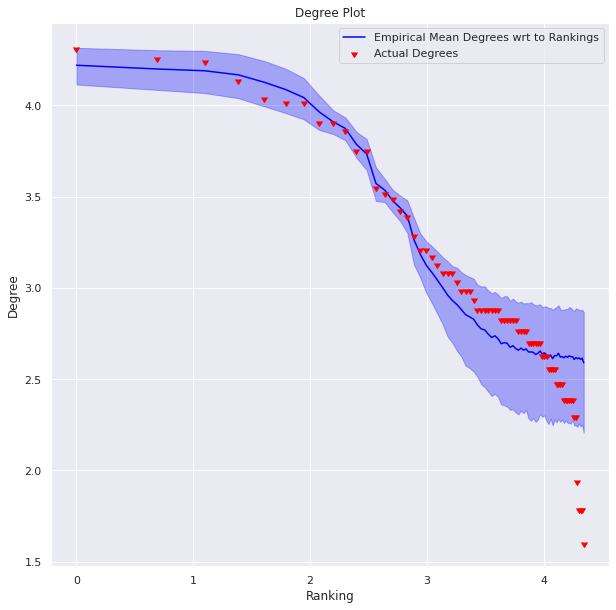

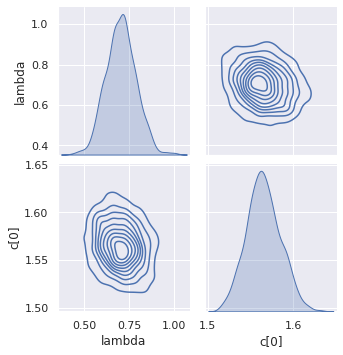

In [ ]:
cigam = CIGAM()
G = load_world_trade()
fit = cigam.fit_model_bayesian(G, [5])
cigam.visualize_degree_plot(G, fit)
cigam.visualize_posterior(fit, params=['lambda', 'c'], pairplot=True)

From the predicted model we generate a new data and infer the posterior ranks

We also fit the following networks

* c-elegans
* history-faculty
* business-faculty

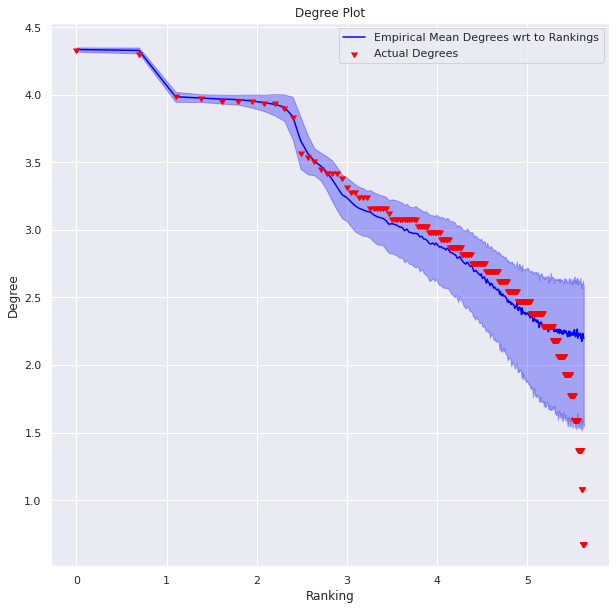

In [ ]:
cigam = CIGAM()
G = load_celegans()
fit = cigam.fit_model_bayesian(G, [3])
cigam.visualize_degree_plot(G, fit)

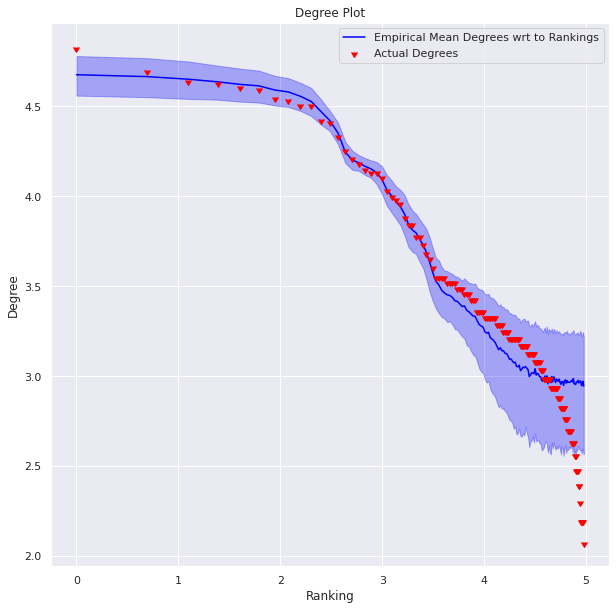

In [ ]:
cigam = CIGAM()
G = load_faculty(location='/content/drive/My Drive/NNIM/data/faculty/History_edgelist.txt', relabel=True)
fit = cigam.fit_model_bayesian(G, [4])
cigam.visualize_degree_plot(G, fit)

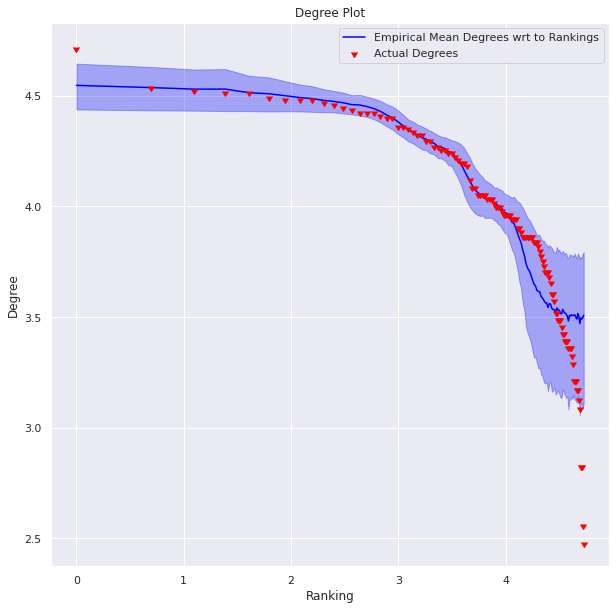

In [ ]:
cigam = CIGAM()
G = load_faculty(location='/content/drive/My Drive/NNIM/data/faculty/Business_edgelist.txt', relabel=True)
fit = cigam.fit_model_bayesian(G, [4])
cigam.visualize_degree_plot(G, fit)

## (Bayesian) Logistic-CP Model (Jia & Benson)

We also sample from a Bayesian version of the Logistic-CP model from Jia and Benson, based on the following Bayesian model 

\begin{align}
  X(u) & \sim \mathrm{Beta}(\alpha, \beta) & \forall u \in V \\
  Z(u) & \sim \mathrm{Exp}(\lambda) & \forall u \in V \\
  \theta(u) &  = (2X(u) - 1) Z(u) & \forall u \in V \\
  X(u, v) | \theta(u), \theta(v) & \sim \mathrm{Bern} \left ( \sigma (\theta(u) + \theta(v) ) \right ) & \forall (u, v) \in V \times V
\end{align}

In [ ]:
def sigmoid(x):
  return 1 / (1 + np.exp(-x))

class LogisticCP:

  def __init__(self, lambda_=1, alpha=2, beta=2):
    self.lambda_ = lambda_
    self.alpha = alpha
    self.beta = beta

    self.stan_definitions = {
        'N' : 'int N;',
        'A' : 'int<lower=0, upper=1> A[N, N];',
        'alpha' : 'real<lower=0> alpha;',
        'beta' : 'real<lower=0> beta;',
        'lambda' : 'real<lower=0> lambda;',
        'coins' : 'real<lower=0, upper=1> coins[N];',
        'intermediate_thetas' : 'real<lower=0> intermediate_thetas[N];'
    }

  @property
  def mu(self):
    return 1 / self.lambda_

  @mu.getter
  def mu(self):
    return 1 / self.lambda_

  @mu.setter
  def mu(self, mu_):
    assert(mu_ > 0)
    self.lambda_ = 1 / mu_

  def sample(self, n):
    # thetas = -np.sort(-np.random.normal(loc=self.mu, scale=self.sigma, size=n))
    coins = np.random.beta(self.alpha, self.beta, size=n)
    intermediate_thetas = np.random.exponential(scale=1 / self.lambda_, size=n)
    thetas = - np.sort(-(2 * coins - 1) * intermediate_thetas)

    G = nx.Graph()

    for u in range(n):
      G.add_node(u)
      for v in range(u):
        if u != v and np.random.uniform() <= sigmoid(thetas[u] + thetas[v]):
          G.add_edge(u, v)

    return G, coins, intermediate_thetas, thetas

  def plot_sample(self, n):
    G, coins, thetas = self.sample(n)
    A = nx.to_numpy_array(G)
    plt.figure(figsize=(10, 10))
    plt.imshow(A)
    plt.title('Adjacency Matrix for G ~ logstic-CP($\mu$={}, $a$={}, $b$={})'.format(self.mu, self.alpha, self.beta))
    plt.xlabel('Ranked Nodes by $\\theta(u)$')
    plt.ylabel('Ranked Nodes by $\\theta(u)$')
    plt.figure(figsize=(10, 10))
    log_rank = np.log(1 + np.arange(A.shape[0]))
    log_degree = np.log(1 + A.sum(0))
    plt.plot(log_rank, log_degree)
    plt.title('Degree Plot')
    plt.xlabel('Node Rank by $\\theta(u)$ (log)')
    plt.ylabel('Node Degree (log)')

    plt.figure(figsize=(10, 10))
    degree_ranks = np.argsort(-log_degree)
    for i in range(A.shape[0]):
      A[i, :] = A[i, degree_ranks]

    for i in range(A.shape[1]):
      A[:, i] = A[degree_ranks, i]

    log_degree = log_degree[degree_ranks]
    plt.imshow(A)
    plt.title('Adjacency Matrix for G ~ logstic-CP($\mu$={}, $a$={}, $b$={})'.format(self.mu, self.alpha, self.beta))
    plt.xlabel('Ranked Nodes by degree')
    plt.ylabel('Ranked Nodes by degree')
    plt.figure(figsize=(10, 10))

    plt.plot(log_rank, log_degree)
    p = np.polyfit(log_rank, log_degree, deg=1)
    alpha_lasso = 0.1
    clf_lasso = linear_model.Lasso(alpha=alpha_lasso)
    clf_lasso.fit(log_rank.reshape(-1, 1), log_degree)
    r2 = np.corrcoef(log_rank, log_degree)[0, 1]
    plt.plot(log_rank, log_degree, linewidth=1, label='Realized Degree $R^2 = {}$'.format(round(r2, 2)))
    plt.plot(log_rank, p[1] + p[0] * log_rank, linewidth=2, label='Linear Regression')
    plt.plot(log_rank, clf_lasso.intercept_ + clf_lasso.coef_ * log_rank, linewidth=2, label='Lasso Regression ($a = {}$)'.format(alpha_lasso))
    plt.title('Degree Plot')
    plt.xlabel('Node Rank by degree (log)')
    plt.ylabel('Node Degree (log)')
    plt.legend()

  def stan_model(self, known, dump=True, load=True):

    functions_segment = '''functions {
      real sigmoid(real x) {
        return 1 / (1 + exp(-x));
      }
}'''

    model_segment = '''model {
      lambda ~ gamma(2, 2);
      alpha ~ lognormal(0, 1);
      beta ~ lognormal(0, 1);

      for (i in 1:N) {
        coins[i] ~ beta(alpha, beta);
        intermediate_thetas[i] ~ exponential(lambda);
      }

      for (i in 1:N) {
        for (j in 1:N) {
          A[i, j] ~ bernoulli(sigmoid((2 * coins[i] - 1) * intermediate_thetas[i] + (2 * coins[j] - 1) * intermediate_thetas[j]));
        }
      }
}
    '''

    data = []
    params = []
    data_keys = []
    params_keys = []

    for key, val in known.items():
      if val:
        data.append(self.stan_definitions[key])
        data_keys.append(key)
      else:
        params.append(self.stan_definitions[key])
        params_keys.append(key)
    
    data_text = '\n\t'.join(data)
    params_text = '\n\t'.join(params)

    data_segment = 'data {\n\t' + data_text + '\n}'
    params_segment = 'parameters {\n\t' + params_text + '\n}'  

    model_code = '{}\n\n{}\n\n{}\n\n{}'.format(functions_segment, data_segment, params_segment, model_segment)

    model_name = '{}_given_{}'.format('_'.join(params_keys), '_'.join(data_keys))

    if load:
      if os.path.isfile('{}.pickle'.format(model_name)):
        with open('{}.pickle'.format(model_name), 'rb') as f:
          stan_model = pickle.load(f)
        return stan_model
      else: 
        stan_model = pystan.StanModel(model_code=model_code, model_name=model_name)
    else:
      stan_model = pystan.StanModel(model_code=model_code, model_name=model_name)
      
    if dump:
      with open('{}.pickle'.format(model_name), 'wb+') as f:
        pickle.dump(stan_model, f, protocol=-1)
      with open('{}.stan'.format(model_name), 'w+') as f:
        f.write(model_code)

    return stan_model

  def stan_model_sample(self, known, model_data, dump=True, load=True):
    stan_model = self.stan_model(known, dump=dump, load=load)
    fit = stan_model.sampling(data=model_data, iter=500, chains=4, seed=1)
    return fit

  def params_posterior(self):
    known = {
        'N' : True, 
        'A' : True,
        'coins' : True, 
        'intermediate_thetas' : True,
        'alpha' : False,
        'beta' : False,
        'lambda' : False
    }

    return known

  def latent_posterior(self):
    known = {
        'N' : True, 
        'A' : True,
        'coins' : False, 
        'intermediate_thetas' : False,
        'alpha' : True,
        'beta' : True,
        'lambda' : True
    }

    return known

  def params_latent_posterior(self):
    known = {
        'N' : True, 
        'A' : True,
        'coins' : False, 
        'intermediate_thetas' : False,
        'alpha' : False,
        'beta' : False,
        'lambda' : False
    }

    return known

  def visualize_posterior(self, fit, params=None, pairplot=False):

    if params is None:
      params = list(fit.extract().keys())

    df = stanfit_to_dataframe(fit, params)

    params = [col for col in df.columns]

    if pairplot:
      sns.pairplot(df, x_vars=params, y_vars=params, kind='kde')
      
    else:
      fig, ax = plt.subplots(figsize=(10, 10))
      colors = iter(cm.rainbow(np.linspace(0, 1, len(params))))

      for param in params:
        if param == 'lp__':
          continue
        c = next(colors)
        param_mean = round(df[param].mean(), 2)
        param_std = round(df[param].std(), 2)
        sns.histplot(df[param], kde=True, label='{} (mean = {}, std = {})'.format(param, param_mean, param_std), ax=ax, color=c)

      plt.xlabel('Parameters')
      plt.ylabel('Posterior')
      plt.legend()

logistic_cp = LogisticCP(lambda_=1/3, alpha=1, beta=4)

G, coins, intermediate_thetas, thetas = logistic_cp.sample(50)

data = {
    'N' : len(G),
    'A' : nx.to_numpy_array(G).astype(np.int64),
    # 'alpha' : 1,
    # 'beta' : 4,
    # 'lambda' : 1/3
    'coins' : coins,
    'intermediate_thetas' : intermediate_thetas
}

fit = logistic_cp.stan_model_sample(logistic_cp.params_posterior(), model_data=data)

logistic_cp.visualize_posterior(fit, params=['alpha', 'beta', 'lambda'], pairplot=True)

INFO:pystan:COMPILING THE C++ CODE FOR MODEL alpha_beta_lambda_given_N_A_coins_intermediate_thetas_f7bd85f5aa1f0785cfb23c6c3128dc18 NOW.


KeyboardInterrupt: ignored

## Logistic-TH (Tudisco & Higham)

In [ ]:
def generalized_mean(x, p):
  if np.isinf(p):
    return np.max(x)
  elif np.isinf(-p):
    return np.min(x)
  else:
    return np.linalg.norm(x) / len(x)**(1 / p)

class LogisticTH:

  def __init__(self, p=20):
    self.p = p
  
  def sample(self, n):
    G = nx.Graph()

    ranks = n - (1 + np.arange(n))

    for u in range(n):
      G.add_node(u)
      for v in range(u):
        if u != v and np.random.uniform() <= sigmoid(generalized_mean([ranks[u], ranks[v]], self.p) / n):
          G.add_edge(u, v)

    return G, ranks

  def display_p(self):
    if np.isinf(self.p):
      return '\\infty'
    elif np.isinf(-self.p):
      return '- \\infty'
    else:
      return self.p

  def plot_sample(self, n):
    G, ranks = self.sample(n)
    A = nx.to_numpy_array(G)
    plt.figure(figsize=(10, 10))
    plt.imshow(A)
    plt.title('Adjacency Matrix for G ~ logstic-TH($p={}$)'.format(self.display_p()))
    plt.xlabel('Ranked Nodes by $\\pi(u)$')
    plt.ylabel('Ranked Nodes by $\\pi(u)$')
    plt.figure(figsize=(10, 10))
    log_rank = np.log(1 + np.arange(A.shape[0]))
    log_degree = np.log(1 + A.sum(0))
    plt.plot(log_rank, log_degree)
    plt.title('Degree Plot')
    plt.xlabel('Node Rank by $\\pi(u)$ (log)')
    plt.ylabel('Node Degree (log)')
    plt.legend()

    plt.figure(figsize=(10, 10))
    degree_ranks = np.argsort(-log_degree)
    for i in range(A.shape[0]):
      A[i, :] = A[i, degree_ranks]

    for i in range(A.shape[1]):
      A[:, i] = A[degree_ranks, i]

    log_degree = log_degree[degree_ranks]
    plt.imshow(A)
    plt.title('Adjacency Matrix for G ~ logstic-TH($p={}$)'.format(self.display_p()))
    plt.xlabel('Ranked Nodes by degree')
    plt.ylabel('Ranked Nodes by degree')
    plt.figure(figsize=(10, 10))

    plt.plot(log_rank, log_degree)
    p = np.polyfit(log_rank, log_degree, deg=1)
    alpha_lasso = 0.1
    clf_lasso = linear_model.Lasso(alpha=alpha_lasso)
    clf_lasso.fit(log_rank.reshape(-1, 1), log_degree)
    r2 = np.corrcoef(log_rank, log_degree)[0, 1]
    plt.plot(log_rank, log_degree, linewidth=1, label='Realized Degree $R^2 = {}$'.format(round(r2, 2)))
    plt.plot(log_rank, p[1] + p[0] * log_rank, linewidth=2, label='Linear Regression')
    plt.plot(log_rank, clf_lasso.intercept_ + clf_lasso.coef_ * log_rank, linewidth=2, label='Lasso Regression ($a = {}$)'.format(alpha_lasso))
    plt.title('Degree Plot')
    plt.xlabel('Node Rank by degree (log)')
    plt.ylabel('Node Degree (log)')
    plt.legend()

  def fit(self, G, alpha=10):
    q = self.p / (self.p - 1)
    n = len(G)

    def helper(x, G, alpha):
      F = np.zeros_like(x)

      for i in G:
        for j in G.neighbors(i):
          F[i] += np.abs(x[i])**(alpha - 2) * x[i] * (x[i]**alpha + x[j]**alpha) ** (1 / (alpha) - 1)

      return F

    x = np.ones(shape=n)
    y = np.ones(shape=n)

    x_prev = x

    for i in range(100):
      y = helper(x, G, alpha)
      x = np.linalg.norm(y, q)**(q - 1) * np.abs(y)**(q - 2) * y
      if np.allclose(x, x_prev):
        break
      else:
        x_prev = x

    ranks = np.argsort(-x)[::-1]

    return x, ranks

## Sampling Hypergraphs 

### Grass-hopping Helper Functions

Below we define the following command to sample hyperedges of the following form:

1. We are given a ground set $S$ of nodes that must belong to the hyperedge and a number $k > |S|$ that indicates the size of the hyperedges. 
2. We are given a probability $p \in (0, 1)$ such that each hyperedge is generated with probability $p$.
3. We are given a set $Q$ from which the other vertices of the hyperedge are sampled upon. 

### Efficient Sampling of CIGAM graphs (for $p = \infty$)

We efficiently generate $k$-uniform CIGAM hypergraphs for $p = \infty$ as follows given a target size $n$ for the network and the parameters $b, c$.

1. We sample $n$ ranks $r(u)$ from the truncated exponential density and order them in decreasing order, that corresponds to the nodes $u_1, \dots, u_n$. 
2. For each $i \in [n]$ we do ball dropping:
  1. We generate $m_i \sim \mathrm{Bin} \left ( \binom {n - i} {k - 1}, c^{-1-H + r(u_i) } \right )$.
  2. Generate $m_i$ edges by sampling $k - 1$ combinations uniformly at random (w/ rejection sampling) and create $k$-simplices from each pair and $u_i$. 


### Efficient Evaluation of the Log-likelihood

Given the heights vector $h$ in increasing order and a $k$-uniform hypergraph $H$ with $n$ nodes one wants to calculate the log-likelihood of the complete data $$\log p(G, h | b, c) = \log p(h | b, c) + \log p(G | h, b, c)$$

The first term $\log p(h | b, c)$ can be exactly calculated in $O(n)$ time. However, exactly copmuting $\log p(G | h, b, c)$ takes time $O(n^k)$ since every $k$-edge or non-edge should be taken into account. Thus we wish to have a randomized procedure that returns an unbiased estimate $\widehat {\log p (G | h, b, c)}$ such that $\mathbb E [ \widehat {\log p (G | h, b, c)} ] = \log p(G | h, b, c)$. 

To construct this estimator, we define the order 

$$v \succ u \iff \left ( h(v) > h(u) \right ) \vee \left ( h(v) = h(u) \wedge v > u \right )$$

This defines a partition of the edges 

\begin{align}
E & = \bigcup_{u \in V} E(u)  \\
E(u) \cap E(v) & = \emptyset & \forall u \neq v
\end{align}

s.t. every edge in $E(u)$ is characterized only by $h(u)$, i.e. appears with probability $c^{-1-h(u)}$. Thus the likelihood is expressed as 

\begin{align}
  \log p (G | h, b, c) = \sum_{u \in V} \left [ |E(u)| \log c^{-1-h(u)} + |\bar E(u)| \log (1 - c^{-1-h(u)}) \right ]
\end{align}

The vertex set induced by $E(u_i)$, which is positioned at index $i \in \{ 1, \dots, n \}$ can have at most $\binom{n - i} {k - 1}$ undirected edges. The exact likelihood requires finding the regions $\{ E(u) \}_{u \in V}$ and calculating their size, which yields a computation time of $O(n \log n + m)$ which in the worst case can cost up to $O(n \log n + n^k)$. Thus to estimate the likelihood due to node $u$ we create a random variable 

$$\mathcal E(u_i) \sim \mathrm{Bin} \left ( \binom {n - i} {k - 1}, c^{-1-h(u_i)} \right ) $$

And the corresponding part of the likelihood estimator would be 

\begin{equation}
  \mathcal E(u_i) \log c^{-1-h(u_i)} + \left ( \binom {n - i} {k - 1} - \mathcal E(u_i) \right ) \log (1 - c^{-1-h(u_i)})  
\end{equation}

Assuming that each binomial $\mathrm {Bin}(n, p)$ can be produced in expected time $O(n^{1/2 + \varepsilon})$ with probability $1 - O(1 / n)$ assuming that $\Omega (\log n)$ bits can be processed in $O(1)$ time, we get an evaluation time of roughly

$$O \left ( n \log n  + \sqrt {n^{(k + 1) + \varepsilon}} \right ) = o(n^k)$$

i.e. is sublinear in $n^k$. 

In [ ]:
def int2base(x, base):
    digits = []

    while x:
        digits.append(x % base)
        x //= base

    return digits

def grass_hopping_helper(S, V, k, p, directed=True):
  assert(k > len(S))
  n = len(V)
  s = len(S)
  i = -1

  edges = set()

  q = p

  while True: 
    i += np.random.geometric(q)
    decoded = int2base(i, n)

    if len(decoded) > k - s:
      break
    else:
      simplex = tuple(S + [V[int(j)] for j in decoded])
      # Perform rejection sampling if the graph is undirected
      if directed or ((not directed) and decoded == list(sorted(decoded))):
        edges.add(simplex)
    
  return edges

def sample_combination(n, k):
  S = set([])

  # Generate combinations uniformly with rejection sampling
  while len(S) < k:
    u = np.random.randint(low=0, high=n-1)
    if u not in S:
      S |= {u}

  return list(S)        

def ball_dropping_helper(S, V, k, p, directed=True):
    assert(k > len(S))
    n = len(V)
    s = len(S)

    if directed:
      m = int(np.random.binomial(n**(k - s), p))   
    else:
      m = int(np.random.binomial(special.comb(n, k - s), p))

    edges = set()                           
    while len(edges) < m:
        if directed:
          e_index = np.random.randint(low=0, high=n, size=k-s)
        else:
          e_index = sample_combination(n, k - s)
        e = tuple(S + [V[idx] for idx in e_index])
        if e not in edges:                  
            edges.add(e)                    
    return list(edges)                      

In [ ]:
class CIGAMHyper:
  def __init__(self, b=3, c=1.5, H=4, order=3, sampling_helper=ball_dropping_helper):
    self.b = b
    self.c = c
    self.H = H
    self.order = order
    self.sampling_helper = ball_dropping_helper

  def sample(self, N, return_ranks=True):
    h = self.continuous_tree_sample(N=N)
    ranks = np.argsort(h)
    h = h[ranks]
    H = Hypergraph()

    for i in range(ranks.shape[0] - self.order):
      batch = self.sampling_helper(S=[ranks[i]], V=ranks[i+1:], p=self.c**(-1-h[i]), k=self.order, directed=False)
       
      for edge in batch:
        H.add_simplex_from_nodes(nodes=edge, timestamp=None)

    if return_ranks:
      return H, self.H - h
    else:
      return H, h

  def continuous_tree_sample(self, N):
    u = np.random.uniform(size=N)
    y = np.log(u * (self.b**self.H - 1) + 1) / np.log(self.b) 
    return y

  def plot_sample(self, n):
    assert(self.order == 2)
    H, h = self.sample(n)
    G = H.clique_decomposition()
    A = nx.to_numpy_array(G)

    degree_ranks = np.argsort(-A.sum(0))
  
    for i in range(A.shape[0]):
      A[i, :] = A[i, degree_ranks]

    for i in range(A.shape[1]):
      A[:, i] = A[degree_ranks, i]

    plt.figure(figsize=(10, 10))
    plt.imshow(A)
    plt.title('Adjacency Matrix for G ~ CIGAM($c$={}, $b$={}, $H$={}) (w/ ball dropping)'.format(self.c, self.b, self.H))
    plt.xlabel('Ranked Nodes by $h(u)$')
    plt.ylabel('Ranked Nodes by $h(u)$')
    plt.figure(figsize=(10, 10))
    log_rank = np.log(1 + np.arange(A.shape[0]))
    log_degree = np.log(1 + A.sum(0))
    log_degree = -np.sort(-log_degree)
    p = np.polyfit(log_rank, log_degree, deg=1)
    alpha_lasso = 0.1
    clf_lasso = linear_model.Lasso(alpha=alpha_lasso)
    clf_lasso.fit(log_rank.reshape(-1, 1), log_degree)
    r2 = np.corrcoef(log_rank, log_degree)[0, 1]
    plt.plot(log_rank, log_degree, linewidth=1, label='Realized Degree $R^2 = {}$'.format(round(r2, 2)))
    plt.plot(log_rank, p[1] + p[0] * log_rank, linewidth=2, label='Linear Regression')
    plt.plot(log_rank, clf_lasso.intercept_ + clf_lasso.coef_ * log_rank, linewidth=2, label='Lasso Regression ($a = {}$)'.format(alpha_lasso))
    plt.xlabel('Node Rank by $h(u)$ (log)')
    plt.ylabel('Node Degree (log)')
    plt.title('Degree Plot')
    plt.legend()
  

  

# Plot a 2-order-hypergraph (i.e. graph) with the ball-dropping technique
cigam_hyper = CIGAMHyper(order=2)
cigam_hyper.plot_sample(1000)

# Plot a graph with naive sampling
cigam = CIGAM()
cigam.plot_sample(1000)